### Load Asset Prices

In [1]:
# Qiskit Finance Time Series Tutorial:

# https://github.com/qiskit-community/qiskit-finance/blob/main/docs/tutorials/11_time_series.ipynb

In [2]:
import numpy as np
import pandas as pd

import datetime

from matplotlib import pyplot as plt

from qiskit_finance.data_providers import YahooDataProvider

plt.style.use('dark_background')

In [3]:
ASSETS_COUNT = 30

SP_500_PATH = 'datasets/sp_500.xlsx'
DATA_FOLDER = 'datasets/'

START_DATE = datetime.datetime(2021, 9, 26)
END_DATE = datetime.datetime(2022, 9, 26)

ASSET_PRICES_PATH = DATA_FOLDER + 'asset_prices.csv'

sp_500 = pd.read_excel(SP_500_PATH)

symbols = sp_500['Symbol'].to_list()[:ASSETS_COUNT]

if 'CEG' in symbols:
    symbols.remove('CEG')
    symbols.append('NVDA')

# symbols = ['NFLX', 'AAPL', 'META', 'GOOG', 'TSLA', 'AMZN', 'MSFT', 'NVDA']

In [4]:
# Asset prices from Qiskit Data Provider

# https://qiskit.org/ecosystem/finance/apidocs/qiskit_finance.data_providers.html


yahoo_provider = YahooDataProvider(tickers=symbols, start=START_DATE, end=END_DATE)


yahoo_provider.run()

tickers = yahoo_provider._tickers

asset_prices = pd.concat(yahoo_provider._data, axis=1, keys=tickers)

In [5]:
# Or directly from Yahoo Finance

import yfinance as yf

stock_data = yf.download(
    tickers=symbols,
    start=START_DATE, 
    end=END_DATE,
    # group_by="ticker"
)

asset_prices_alt = stock_data["Adj Close"][symbols]

[*********************100%***********************]  30 of 30 completed


In [6]:
# Save asset prices

asset_prices.to_csv(ASSET_PRICES_PATH, index=True)

In [7]:
# Load asset prices

asset_prices = pd.read_csv(ASSET_PRICES_PATH, index_col='Date')

asset_prices.index = pd.to_datetime(asset_prices.index)

tickers = asset_prices.columns.to_list()

In [8]:
asset_prices.head(3)

,AAPL,MSFT,GOOG,GOOGL,AMZN,TSLA,BRK-B,UNH,JNJ,XOM,...,BAC,KO,ABBV,PFE,PEP,COST,MRK,TMO,DHR,AVGO
Date,,,,,,,,,,,,,,,,,,,,,
2021-09-27,143.901489,289.547150,141.501007,141.072006,170.289993,263.786682,279.720001,395.804260,155.655655,55.370705,...,41.471092,50.887959,100.549019,41.008034,145.732422,455.017303,69.457100,592.342346,313.677002,479.980042
2021-09-28,140.476440,279.064514,136.184006,135.830002,165.798004,259.186676,276.790009,389.309631,155.312225,55.949619,...,41.375229,49.967205,100.194305,40.509197,144.138809,441.966309,69.419228,574.193604,301.715607,466.831390
2021-09-29,141.387146,279.537018,134.520996,134.353500,165.056000,260.436676,277.290009,391.057800,156.466492,55.912277,...,41.288952,50.270966,101.594460,40.970387,145.331619,446.352875,71.095055,577.331238,304.566467,465.367249


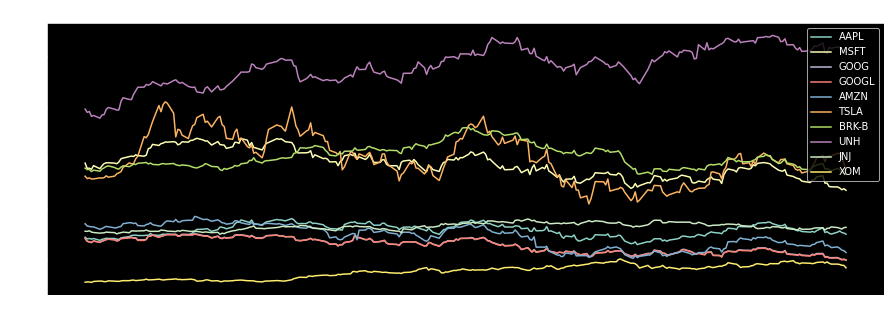

In [9]:
# Plot asset columns

MAX_TICKERS = 10

selected_prices = asset_prices.iloc[:, :MAX_TICKERS]
selected_tickers = tickers[:MAX_TICKERS]

plt.figure(figsize=(15, 5))   
plt.plot(selected_prices, 
         label=selected_tickers)

plt.title("Historical Asset Prices")
plt.ylabel("Price, USD")
plt.legend()
plt.show()

In [10]:
# FMQA Intialization

dataset = PortfolioDataset().load(DATA_FOLDER)

splitter = Splitter(dataset, batch_size=100)

trainer = Trainer(splitter=splitter, embedding_dimensions=16)

initial_dataset_sharpe = dataset.targets

total_iteration = 0

print("updated_dataset.field_dimensions:", dataset.field_dimensions.shape)

NameError: name 'PortfolioDataset' is not defined

In [ ]:
# FMQA Iteration

ITERATIONS_COUNT = 1

INITIAL_EPOCHS_COUNT = 1
EPOCHS_COUNT = 1
DATASET_SHARE = 1

TOP_SIZE = 10
SAMPLE_REPETITIONS_COUNT = 1000

SHOTS_COUNT = 100
PENALTY_VALUE = 10
MAXIMIZE = True

# SAMPLER = SimulatedAnnealingSampler()
# SAMPLER = ORToolsSampler()
SAMPLER = TabuSampler()
# SAMPLER = CutOffComposite(TabuSampler(), cutoff=0.01)

ORTOOLS_TIME_LIMIT = 10

total_iterations_count = total_iteration + ITERATIONS_COUNT


for iteration in range(ITERATIONS_COUNT):
    
    total_iteration += 1
    
    print(f"Iteration {total_iteration}/{total_iterations_count}")
    
    splitter = Splitter(dataset, batch_size=100,
                        dataset_share=DATASET_SHARE)
    
    print("splitter.lengths:", splitter.lengths)

    trainer = Trainer(splitter=splitter,
                      model=trainer.model,
                      optimizer=trainer.optimizer)
       
    epochs_count = INITIAL_EPOCHS_COUNT if total_iteration == 1 else EPOCHS_COUNT
    
    trainer.train(epochs=epochs_count, 
                  validate=False)

    qubo = OneHotQubo(trainer=trainer,
                      penalty_value=PENALTY_VALUE,
                      maximize=MAXIMIZE)

    sampling_results = SAMPLER.sample_qubo(Q=qubo.qubo_coefficients, 
                                           num_reads=SHOTS_COUNT,
                                           time_limit=ORTOOLS_TIME_LIMIT)
    
    aggregated_results = sampling_results.aggregate()

    filtered_results = aggregated_results.filter(pred=qubo.is_correct_one_hot)
    
    results = portfolio_decode_sampling_results(filtered_results)
    
    
    # New data
    
    new_fields, new_targets = portfolio_get_top_results(results, top_size=TOP_SIZE)
    
   
    # Append to Dataset
    
    dataset.append_records(new_fields, new_targets, SAMPLE_REPETITIONS_COUNT)
    
    print(f"new_targets.max(): {new_targets.max():.02f}")
    print(f"dataset.targets.max(): {dataset.targets.max():.02f}")
    print(f"initial_dataset_sharpe.max(): {initial_dataset_sharpe.max():.02f}")        
        
plot_dataset()
# plot_samples()
# plot_top_samples()
# plot_sharpe_convergence()
# plot_dataset_histograms()

In [ ]:
# Load asset prices

ASSET_PRICES_PATH = 'datasets/01/asset_prices.csv'

asset_prices = pd.read_csv(ASSET_PRICES_PATH, index_col='Date')

asset_prices.index = pd.to_datetime(asset_prices.index)

tickers = asset_prices.columns.to_list()


# Top results

top_result = results.sort_values('sharpe', ascending=False).head(1)

top_portfolio = top_result.portfolio.item().astype(bool)

top_prices = asset_prices.iloc[:, top_portfolio]

top_tickers = top_prices.columns.to_numpy().squeeze()

print(f"top_sharpe: {top_result.sharpe.item():.02f}")
print("top_portfolio:", top_portfolio.astype(int))
print("top_tickers:", top_tickers)

In [ ]:
# Plot Top Portfolio

MAX_TICKERS = 10
MAX_TOP_TICKERS = 10

selected_prices = asset_prices.iloc[:, :MAX_TICKERS]
selected_tickers = tickers[:MAX_TICKERS]

if top_tickers.shape == ():    
    top_tickers = top_tickers.reshape(-1, 1)

plt.figure(figsize=(15, 5))   
plt.plot(selected_prices, 
         label=selected_tickers,
         alpha=0.7)

# plt.gca().set_prop_cycle(color='rgbcmy')
plt.gca().set_prop_cycle(color='r')

plt.plot(top_prices.iloc[:, :MAX_TOP_TICKERS], 
         label=top_tickers[:MAX_TOP_TICKERS],
         # label=top_tickers,
         linewidth=4,
         alpha=0.7)

plt.title("Top Portfolio")
plt.ylabel("Price, USD")
plt.legend()
plt.show()

In [ ]:
from braket.aws import AwsDevice
from braket.ocean_plugin import BraketDWaveSampler
from dwave.system.composites import EmbeddingComposite

from dwave_qbsolv import QBSolv

from braket.tracking import Tracker

cost_tracker = Tracker().start()

COST_LIMIT = 10

In [ ]:
# DWave Device

dwave_2000q_arn = 'arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6'
dwave_advantage_4_arn = 'arn:aws:braket:::device/qpu/d-wave/Advantage_system4'
dwave_advantage_6_arn = 'arn:aws:braket:us-west-2::device/qpu/d-wave/Advantage_system6'

dwave_arn = dwave_2000q_arn
# dwave_arn = dwave_advantage_6_arn

device = AwsDevice(dwave_arn)

print(f"device.name:", device.name)
print(f"device.properties.provider.topology:", device.properties.provider.topology)
print(f"device.properties.provider.qubitCount:", device.properties.provider.qubitCount)
print(f"len(device.properties.provider.couplers):", len(device.properties.provider.couplers))
print(f"device.properties.service.shotsRange:", device.properties.service.shotsRange)
print(f"device.properties.service.deviceLocation:", device.properties.service.deviceLocation)

In [ ]:
# DWave Samplers

dwave_sampler = BraketDWaveSampler(dwave_arn)
embedded_sampler = EmbeddingComposite(dwave_sampler)

In [ ]:
# Initialize FMQA Loop

DATA_FOLDER = 'datasets/01/'

dataset = PortfolioDataset().load(DATA_FOLDER)

# sampler = SimulatedAnnealingSampler()
sampler = TabuSampler()

splitter = Splitter(dataset, batch_size=100)

trainer = Trainer(splitter=splitter, embedding_dimensions=16)

sharpe_mins = []
sharpe_maxs = []
sharpe_means = []

initial_dataset_sharpe = dataset.targets

total_iteration = 0

print("updated_dataset.field_dimensions:", dataset.field_dimensions.shape)

In [ ]:
ITERATIONS_COUNT = 1

INITIAL_EPOCHS_COUNT = 1
EPOCHS_COUNT = 1
DATASET_SHARE = 1

TOP_SIZE = 10
SAMPLE_REPETITIONS_COUNT = 1000

SHOTS_COUNT = 1000
PENALTY_VALUE = 1
MAXIMIZE = True

REAL_DEVICE = False
# REAL_DEVICE = True

total_iterations_count = total_iteration + ITERATIONS_COUNT


for iteration in range(ITERATIONS_COUNT):
    
    current_tasks_cost = cost_tracker.qpu_tasks_cost()

    if current_tasks_cost >= COST_LIMIT:

        raise AssertionError('AWS Braket cost limit reached:', current_tasks_cost)
        
    
    total_iteration += 1
    
    print(f"Iteration {total_iteration}/{total_iterations_count}")
    
    splitter = Splitter(dataset, batch_size=100,
                        dataset_share=DATASET_SHARE)
    
    print("splitter.lengths:", splitter.lengths)

    trainer = Trainer(splitter=splitter, embedding_dimensions=16,
                      model=trainer.model,
                      optimizer=trainer.optimizer)
       
    if total_iteration == 1:
        epochs_count = INITIAL_EPOCHS_COUNT
    else:
        epochs_count = EPOCHS_COUNT
    
    trainer.fit(epochs=epochs_count, validate=False)

    qubo = PortfolioQubo(trainer=trainer,
                         penalty_value=PENALTY_VALUE,
                         maximize=MAXIMIZE)
    
    
    # Sampling
    
    chosen_sampler = embedded_sampler if REAL_DEVICE else sampler
        
    print("chosen_sampler:", chosen_sampler)
    print("Sampling...") 

    # sampling_results = chosen_sampler.sample_qubo(Q=qubo.qubo_coefficients, num_reads=SHOTS_COUNT)
    
    sampling_results = QBSolv().sample_qubo(Q=qubo.qubo_coefficients,
                                            # solver='tabu',
                                            # solver=TabuSampler(),
                                            # solver=embedded_sampler,
                                            solver_limit=100, 
                                            # verbosity=1,
                                            num_reads=SHOTS_COUNT)   
        
    print("Sampling complete")    
    
    
    aggregated_results = sampling_results.aggregate()

    filtered_results = aggregated_results.filter(pred=qubo.is_correct_one_hot)
    
    
    # Decode

    results = []

    for sample in filtered_results.data():

        result = sample.sample

        one_hot_array = np.array(list(sample.sample.values()))    
        
        portfolio = qubo.one_hot_to_bits(one_hot_array)
        
        decimal = sum(number * 2 ** position for position, number in enumerate(reversed(portfolio)))

        result['portfolio'] = portfolio
        result['decimal'] = decimal

        result['energy'] = sample.energy
        result['num_occurrences'] = sample.num_occurrences

        results.append(result)

    results = pd.DataFrame(results)
    
    if results.shape[0] == 0:
        print("No Samples")
        continue
    
    # Real Sharpe
    
    results['risk'] = dataset.sharpe.get_risks(results.portfolio, dataset.sigma)
    results['return'] = dataset.sharpe.get_returns(results.portfolio, dataset.mu)
    
    results.risk.replace(0, 0.000001, inplace=True)

    results['sharpe'] = results['return'] / results['risk']
    
    # New data
    
    new_fields, new_targets = portfolio_get_top_results(results, top_size=TOP_SIZE)
    
    
    # Append to Dataset
    
    new_rows_count = new_fields.shape[0] * SAMPLE_REPETITIONS_COUNT
    
    new_fields_array = np.tile(new_fields, (SAMPLE_REPETITIONS_COUNT, 1))
    new_targets_array = np.tile(new_targets, (SAMPLE_REPETITIONS_COUNT, 1)).ravel()
    
    dataset.fields = np.vstack((dataset.fields, new_fields_array))
    dataset.targets = np.concatenate((dataset.targets, new_targets_array)) 
    
    
    # Sharpe Dynamics
    
    max_sharpe = new_targets.max()
    mean_sharpe = new_targets.mean()
    min_sharpe = new_targets.min()
    
    sharpe_maxs.append(max_sharpe)    
    sharpe_means.append(mean_sharpe)
    sharpe_mins.append(min_sharpe)

    print(f"new_targets.max(): {new_targets.max():.02f}")
    print(f"dataset.targets.max(): {dataset.targets.max():.02f}")
    print(f"initial_dataset_sharpe.max(): {initial_dataset_sharpe.max():.02f}")
    
    if max_sharpe == mean_sharpe == min_sharpe:
        
        print("Converged:", mean_sharpe)
        break
        
        
plot_dataset()
plot_samples()
plot_top_samples()
plot_sharpe_convergence()
plot_dataset_histograms()

In [ ]:
dataset = PortfolioDataset()
dataset.load(DATA_FOLDER)

initial_dataset_sharpe = dataset.targets

sharpe_mins = []
sharpe_maxs = []
sharpe_means = []

total_iteration = 0

In [ ]:
ITERATIONS_COUNT = 1
MC_SAMPLES_COUNT = 1000000

TOP_SIZE = 10
SAMPLE_REPETITIONS_COUNT = 1000

ASSETS_COUNT = dataset.fields.shape[1]

total_iterations_count = total_iteration + ITERATIONS_COUNT


for iteration in range(ITERATIONS_COUNT):
    
    total_iteration += 1
    
    print(f"Iteration {total_iteration}/{total_iterations_count}")
    
    portfolios = np.random.randint(0, 2, size=(MC_SAMPLES_COUNT, ASSETS_COUNT))
    
    results = pd.DataFrame(portfolios)
    
    results['sharpe'] = dataset.sharpe.get_sharpe(portfolios, dataset.sigma, dataset.mu)
    
    top_results = results.sort_values('sharpe', ascending=False)[:TOP_SIZE]

    new_fields = top_results.iloc[:, :ASSETS_COUNT]

    new_targets = top_results.sharpe.to_numpy()
       
    
    # Append to Dataset
    
    new_rows_count = new_fields.shape[0] * SAMPLE_REPETITIONS_COUNT
    
    new_fields_array = np.tile(new_fields, (SAMPLE_REPETITIONS_COUNT, 1))
    new_targets_array = np.tile(new_targets, (SAMPLE_REPETITIONS_COUNT, 1)).ravel()
    
    dataset.fields = np.vstack((dataset.fields, new_fields_array))
    dataset.targets = np.concatenate((dataset.targets, new_targets_array)) 
    
    
    # Sharpe Dynamics
    
    max_sharpe = new_targets.max()
    mean_sharpe = new_targets.mean()
    min_sharpe = new_targets.min()
    
    sharpe_maxs.append(max_sharpe)    
    sharpe_means.append(mean_sharpe)
    sharpe_mins.append(min_sharpe)

    print(f"new_targets.max(): {new_targets.max():.02f}")
    print(f"dataset.targets.max(): {dataset.targets.max():.02f}")
    print(f"initial_dataset_sharpe.max(): {initial_dataset_sharpe.max():.02f}")
    
    if max_sharpe == mean_sharpe == min_sharpe:
        
        print("Converged:", mean_sharpe)
        break
        

plt.figure(figsize=(15, 5))
plt.title("Dataset")
plt.xlabel("Row")
plt.ylabel("Sharpe Ratio")

plt.plot(dataset.targets,
         # color='C7',
         color='grey')
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(sharpe_maxs, label="Sharpe Ratio Maximum")
plt.plot(sharpe_means, label="Sharpe Ratio Mean")
plt.plot(sharpe_mins, label="Sharpe Ratio Minimum")

plt.title("Sharpe Ratio Convergence")
plt.xlabel("Iteration")
plt.ylabel("Sharpe Ratio")

plt.legend()
plt.show()

In [ ]:
DATA_FOLDER = 'datasets/01/'

dataset = PortfolioDataset().load(DATA_FOLDER)

splitter = Splitter(dataset, batch_size=100)

trainer = Trainer(splitter=splitter, embedding_dimensions=16)

print("dataset.field_dimensions:", dataset.field_dimensions)
# print(dataset.data.head())
# dataset.plot_scatter()
print("Splitter lengths:", splitter.lengths) 

In [ ]:
trainer.train(epochs=3, validate=False)

In [ ]:
# Predict

INDEX_STEP = 1000

indices = np.arange(0, len(dataset), INDEX_STEP)

fields = splitter.dataset.fields[indices]
targets = splitter.dataset.targets[indices]

predictions = trainer.predict(fields)

r2_score = sklearn.metrics.r2_score(targets, predictions)

# Plot

plt.figure(figsize=(15, 5))

plt.plot(targets, label=f"Sharpe Ratio - Targets")
plt.plot(predictions, label=f"Sharpe Ratio - Predictions - R2 score {r2_score:.02f}")

plt.locator_params(axis='x', nbins=20)

plt.title("Predictions")
plt.xlabel("Portfolio")
plt.ylabel("Sharpe Ratio")
plt.legend()

plt.show()

In [ ]:
PENALTY_VALUE = 1

MAXIMIZE = True

SHOTS_COUNT = 1000

qubo = OneHotQubo(trainer=trainer,
                  penalty_value=PENALTY_VALUE,
                  maximize=MAXIMIZE)

In [ ]:
# QUBO Energies

INDEX_STEP = 1000

indices = np.arange(0, len(dataset), INDEX_STEP)


# Energies

bqm = dimod.BinaryQuadraticModel.from_qubo(qubo.qubo_coefficients)

quadratic = bqm.quadratic
linear = bqm.linear
offset = bqm.offset

energies = []
bqm_energies = []


for row_bits in dataset.fields[indices]:
    
    one_hot_row = qubo.bits_to_one_hot(row_bits)

    sample = dict(enumerate(one_hot_row))

    energy = dimod.utilities.qubo_energy(sample=sample, Q=qubo.qubo_coefficients)
        
    bqm_energy = dimod.utilities.ising_energy(sample=sample, J=quadratic, h=linear, offset=offset)
    
    energies.append(energy)
    bqm_energies.append(bqm_energy)

    
# Predictions

fields = splitter.dataset.fields[indices]
targets = splitter.dataset.targets[indices]

predictions = trainer.predict(fields)


# General Plot

figure, data_ax = plt.subplots(figsize=(15, 5))
energy_ax = data_ax.twinx()

data_ax.plot(indices, targets, label="Target Sharpe Ratio")
data_ax.plot(indices, predictions, label="Predicited Sharpe Ratio", color='#fdb462')
energy_ax.plot(indices, energies, label="QUBO Energy", color='#fa8174', alpha=0.5)
# energy_ax.plot(indices, bqm_energies, label="BQM Energy", color='r')

energy_ax.invert_yaxis()

plt.title('Sharpe Ratios and corresponding Energies')
data_ax.set_xlabel("Portfolio")
data_ax.set_ylabel("Sharpe Ratio")
energy_ax.set_xlabel("Portfolio")
energy_ax.set_ylabel("QUBO Energy")

figure.legend(bbox_to_anchor=(0.895, 0.87))

plt.show()

In [ ]:
sampler = SimulatedAnnealingSampler()

# new_bqm = dimod.BinaryQuadraticModel(bqm.linear,
#                                      bqm.quadratic,
#                                      bqm.offset,
#                                      vartype=dimod.BINARY)

# spin_bqm = new_bqm.change_vartype(dimod.SPIN, inplace=False)


sampling_results = sampler.sample_qubo(Q=qubo.qubo_coefficients, num_reads=SHOTS_COUNT)

# sampling_results = sampler.sample_qubo(Q=range_qubo_coefficients, num_reads=shots_count)

# sampling_results = sampler.sample_qubo(Q=excluded_qubo_coefficients, num_reads=shots_count)


# sampling_results = sampler.sample_ising(J=bqm.quadratic, h=bqm.linear, num_reads=shots_count)

# new_linear = {k[0]: v for k, v in qubo.qubo_coefficients.items() if k[0] == k[1]}

# sampling_results = sampler.sample_ising(J=qubo.qubo_coefficients, h=new_linear, num_reads=shots_count)

# sampling_results = sampler.sample(bqm=spin_bqm, num_reads=shots_count)

In [ ]:
aggregated_results = sampling_results.aggregate()

filtered_results = aggregated_results.filter(pred=qubo.is_correct_one_hot)

print("sampling_results:", len(sampling_results))
print("aggregated_results:", len(aggregated_results))
print("filtered_results:", len(filtered_results))

In [ ]:
# Decode

decoded_results = []

for sample in filtered_results.data():
    
    result = sample.sample
    
    one_hot_array = np.array(list(sample.sample.values()))
    portfolio = qubo.one_hot_to_bits(one_hot_array)
    decimal = sum(number * 2 ** position for position, number in enumerate(reversed(portfolio)))
    
    result['portfolio'] = portfolio
    result['decimal'] = decimal
    
    result['energy'] = sample.energy
    result['num_occurrences'] = sample.num_occurrences
    
    decoded_results.append(result)
    
decoded_results = pd.DataFrame(decoded_results)

# pd.set_option('display.max_rows', 10)

# print("maximize:\n", MAXIMIZE)
# print("decoded_results.head:\n", decoded_results.head())

In [ ]:
# Plot Samples

results = decoded_results.sort_values('decimal')

portfolios = results['portfolio'].to_numpy()
decimals = results['decimal'].to_numpy()
energies = results['energy'].to_numpy()
sizes = results['num_occurrences'].to_numpy()
    
sizes = sizes - min(sizes)
sizes = sizes ** 10
sizes = sizes / (max(sizes) or 1) * 100 
sizes[sizes < 1] = 1

plt.figure(figsize=(15, 5))

plt.plot(decimals, energies, 
         color='C5', 
         # color='C1', 
         alpha=0.5)

plt.scatter(decimals, energies,
            label=f"Occurrences",
            color='#fdb462',
            # color='C1', 
            s=sizes + 1)

plt.ticklabel_format(style='plain', useOffset=False)

plt.title("Annealing Samples")
plt.xlabel("Portfolio")
plt.ylabel("Energy")
plt.legend()

# plt.gca().invert_yaxis()

plt.show()

In [ ]:
# Sharpe Ratio Predictions for samples

trainer.model.eval()

portfolios_array = np.stack(results.portfolio).astype(int)

with torch.no_grad():

    predictions_for_samples = trainer.model(torch.tensor(portfolios_array))

predictions_for_samples

results['prediction'] = predictions_for_samples

In [ ]:
# Real Sharpe Ratios for Samples

INDEX_STEP = 1

sharpes_for_samples = dataset.sharpe.get_sharpe(results.portfolio, dataset.sigma, dataset.mu)

results['sharpe'] = sharpes_for_samples

plt.figure(figsize=(15, 5))

plt.scatter(x=results.decimal[::INDEX_STEP], 
            y=results.sharpe[::INDEX_STEP],
            c=results.sharpe[::INDEX_STEP],
            label="Real Sharpe Ratio",
            s=20)

# plt.plot(results.decimal[::INDEX_STEP], results.sharpe[::INDEX_STEP], color='indigo', alpha=0.5)

plt.ticklabel_format(style='plain', useOffset=False)

plt.title("Real Sharpe Ratios for Samples")
plt.xlabel("Portfolio")
plt.ylabel("Sharpe Ratio")
plt.legend()

# plt.gca().invert_yaxis()

plt.show()

In [ ]:
# Predicted Sharpe Ratios for Samples

INDEX_STEP = 1

sharpes_for_samples = dataset.sharpe.get_sharpe(results.portfolio, dataset.sigma, dataset.mu)

results['sharpe'] = sharpes_for_samples

plt.figure(figsize=(15, 5))

plt.scatter(x=results.decimal[::INDEX_STEP], 
            y=results.prediction[::INDEX_STEP],
            c=results.prediction[::INDEX_STEP],
            label="Predicted Sharpe Ratio",
            s=20)

# plt.plot(results.decimal[::INDEX_STEP], results.prediction[::INDEX_STEP], color='indigo', alpha=0.5)

plt.ticklabel_format(style='plain', useOffset=False)

plt.title("Predicted Sharpe Ratios for Samples")
plt.xlabel("Portfolio")
plt.ylabel("Sharpe Ratio")
plt.legend()

# plt.gca().invert_yaxis()

plt.show()

In [ ]:
# Real and Predicted Sharpe Ratios for Samples

INDEX_STEP = 10

sharpes_for_samples = dataset.sharpe.get_sharpe(results.portfolio, dataset.sigma, dataset.mu)

results['sharpe'] = sharpes_for_samples

plt.figure(figsize=(15, 5))

plt.plot(results.decimal[::INDEX_STEP], results.sharpe[::INDEX_STEP], color='indigo',
         label="Real Sharpe Ratio")
plt.plot(results.decimal[::INDEX_STEP], results.prediction[::INDEX_STEP], color='C3',
         label="Predicted Sharpe Ratio")

plt.ticklabel_format(style='plain', useOffset=False)

plt.title("Real and Predicted Sharpe Ratios for Samples")
plt.xlabel("Portfolio")
plt.ylabel("Sharpe Ratio")
plt.legend()

# plt.gca().invert_yaxis()

plt.show()

In [ ]:
# Dataset Sharpe Ratios

INDEX_STEP = 10

plt.subplots(figsize=(15, 5))

plt.scatter(x=dataset.data.index[::INDEX_STEP],
            y=dataset.data.sharpe[::INDEX_STEP],
            c=dataset.data.sharpe[::INDEX_STEP], 
            s=20)

# plt.plot(results.decimal, results.energy, color='indigo', alpha=0.5)

plt.ticklabel_format(style='plain', useOffset=False)

plt.title("Dataset - Real Sharpe Ratios")
plt.xlabel("Portfolio")
plt.ylabel("Energy")

# plt.gca().invert_yaxis()

plt.show()

In [ ]:
# Top Sharpes by Energy and by Sharpe

FIRST_PART = 100

results_by_energy = results.sort_values('energy', ascending=True)
results_by_sharpe = results.sort_values('sharpe', ascending=False)

plt.figure(figsize=(15, 5))
plt.plot(results_by_energy.index[:FIRST_PART], results_by_energy.sharpe[:FIRST_PART], label='Top by energy', c='C5')
plt.plot(results_by_energy.index[:FIRST_PART], results_by_sharpe.sharpe[:FIRST_PART], label='Top by Sharpe')

plt.title(f"Top Energies and Sharpe ratios of top {FIRST_PART} samples")
plt.xlabel("Sample")
plt.ylabel("Sharpe Ratio")

plt.legend()
plt.show()

In [ ]:
from braket.aws import AwsDevice
from braket.ocean_plugin import BraketDWaveSampler
from dwave.system.composites import EmbeddingComposite

from braket.tracking import Tracker

cost_tracker = Tracker().start()

COST_LIMIT = 1

In [ ]:
# D-Wave 2000Q device
device = AwsDevice("arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6")

# # D-Wave Advantage device
# device = AwsDevice("arn:aws:braket:::device/qpu/d-wave/Advantage_system4")

print(f"device.name:", device.name)
print(f"device.properties.provider.topology:", device.properties.provider.topology)
print(f"device.properties.provider.qubitCount:", device.properties.provider.qubitCount)
print(f"len(device.properties.provider.couplers):", len(device.properties.provider.couplers))
print(f"device.properties.service.shotsRange:", device.properties.service.shotsRange)
print(f"device.properties.service.deviceLocation:", device.properties.service.deviceLocation)

In [ ]:
qubo.coupling_matrix.shape

In [ ]:
dwave_2000q_sampler = BraketDWaveSampler(device_arn='arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6')
embedded_sampler = EmbeddingComposite(dwave_2000q_sampler)

In [ ]:
num_reads = 1000

# if cost_tracker.qpu_tasks_cost() < COST_LIMIT:

    # sampling_results = embedded_sampler.sample_qubo(Q=qubo.qubo_coefficients, num_reads=num_reads)

In [ ]:
print("quantum_tasks_statistics:", cost_tracker.quantum_tasks_statistics())
print("qpu_tasks_cost:", cost_tracker.qpu_tasks_cost())
print("simulator_tasks_cost:", cost_tracker.simulator_tasks_cost())

In [ ]:
# # Save results

# RESULTS_FILENAME = 'quantum_annealing_results/2000q_60_qubits_trained.npy'

# np.save(RESULTS_FILENAME, sampling_results)

In [ ]:
# Load results

RESULTS_FILENAME = 'quantum_annealing_results/2000q_60_qubits_trained.npy'

sampling_results = np.load(RESULTS_FILENAME, allow_pickle=True).item()

In [ ]:
aggregated_results = sampling_results.aggregate()

filtered_results = aggregated_results.filter(pred=qubo.is_correct_one_hot)

print("sampling_results:", len(sampling_results))
print("aggregated_results:", len(aggregated_results))
print("filtered_results:", len(filtered_results))

# print("sampling_results:\n", sampling_results)
# print("aggregated_results:\n", aggregated_results)
# print("filtered_results:\n", filtered_results)

In [ ]:
# Decode

decoded_results = []

for sample in filtered_results.data():
    
    result = sample.sample
    
    one_hot_array = np.array(list(sample.sample.values()))
    portfolio = qubo.one_hot_to_bits(one_hot_array)
    decimal = sum(number * 2 ** position for position, number in enumerate(reversed(portfolio)))
    
    result['portfolio'] = portfolio
    result['decimal'] = decimal
    
    result['energy'] = sample.energy
    result['num_occurrences'] = sample.num_occurrences
    
    decoded_results.append(result)
    
decoded_results = pd.DataFrame(decoded_results)

In [ ]:
# Plot Samples

results = decoded_results.sort_values('decimal')

portfolios = results['portfolio'].to_numpy()
decimals = results['decimal'].to_numpy()
energies = results['energy'].to_numpy()
sizes = results['num_occurrences'].to_numpy()
    
sizes = sizes - min(sizes)
sizes = sizes ** 10
sizes = sizes / (max(sizes) or 1) * 100 
sizes[sizes < 1] = 1

plt.figure(figsize=(15, 5))

plt.plot(decimals, energies, color='C3', alpha=0.5)

plt.scatter(decimals, energies,
            label=f"Occurrences",
            color='#fdb462',
            s=sizes + 1)

plt.ticklabel_format(style='plain', useOffset=False)

plt.title("Annealing Samples")
plt.xlabel("Portfolio")
plt.ylabel("Energy")
plt.legend()

# plt.gca().invert_yaxis()

plt.show()

In [ ]:
# DWave 2000Q Embedding

from braket.ocean_plugin import BraketDWaveSampler


dwave_2000q_sampler = BraketDWaveSampler(device_arn='arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6')

target_nodelist, target_edgelist, target_adjacency = dwave_2000q_sampler.structure

dwave_2000q_embedding = find_embedding(qubo.qubo_coefficients, target_edgelist, verbose=1, interactive=True)

In [ ]:
# Chimera Graph Embedding

import dwave_networkx as dnx
import networkx as nx

one_chimera_graph = dnx.chimera_graph(2, 2, 4)

one_chimera_layout = dnx.chimera_layout(one_chimera_graph)

In [ ]:
nx.draw(one_chimera_graph, pos=one_chimera_layout)

In [ ]:
from minorminer import find_embedding

chimera_graph = dnx.chimera_graph(16, 16, 4)

chimera_embedding = find_embedding(qubo.qubo_coefficients, chimera_graph.edges, verbose=1, interactive=True)

In [ ]:
structured_sampler = dimod.StructureComposite(TabuSampler(),
                                              chimera_graph.nodes,
                                              chimera_graph.edges)

In [ ]:
from dwave.system.composites import FixedEmbeddingComposite

embedded_sampler = FixedEmbeddingComposite(structured_sampler, embedding=chimera_embedding)

In [ ]:
sampling_results = embedded_sampler.sample_qubo(Q=qubo.qubo_coefficients, num_reads=100)

In [ ]:
print(sampling_results)

In [ ]:
# https://docs.ocean.dwavesys.com/en/stable/docs_dimod/reference/generators.html

In [ ]:
# 1) Combinations

bqm = dimod.generators.combinations(3, 1, strength=10, vartype='BINARY')

bqm

In [ ]:
print(dimod.ExactSolver().sample(bqm).lowest())
print()
print(dimod.ExactSolver().sample(bqm))

In [ ]:
# 2) Binary Encoding

bqm = dimod.generators.binary_encoding(v='i', upper_bound=7) + 4

bqm

In [ ]:
bqm.to_qubo()

In [ ]:
print(dimod.ExactSolver().sample(bqm).lowest())
print()
print(dimod.ExactSolver().sample(bqm))

In [ ]:
sample = {('i', 1): 0, ('i', 2): 1, ('i', 4, 'msb'): 1}

bqm.energy(sample)

In [ ]:
sum(v[1]*val for v, val in sample.items()) + bqm.offset

In [ ]:
# 3) Full Adder

bqm = dimod.generators.fulladder_gate('a1', 'a2', 'a3', 's', 'c')

print(dimod.ExactSolver().sample(bqm).lowest())

In [ ]:
# 5) Multiplication

# https://docs.ocean.dwavesys.com/en/stable/docs_dimod/reference/generated/dimod.generators.multiplication_circuit.html#dimod.generators.multiplication_circuit


bqm = dimod.generators.multiplication_circuit(num_arg1_bits=2,
                                              num_arg2_bits=2)

for fixed_var, fixed_val in {'a0': 0, 'a1': 1, 'b0':1, 'b1': 1}.items():
    
    bqm.fix_variable(fixed_var, fixed_val)

best = TabuSampler().sample(bqm).first

p = {key: best.sample[key] for key in best.sample.keys() if "p" in key}

print(p)

In [ ]:
print(dimod.ExactSolver().sample(bqm).lowest())
print()
print(dimod.ExactSolver().sample(bqm))

In [ ]:
from dwave_qbsolv import QBSolv

In [ ]:
# from hybrid.reference.qbsolv import SimplifiedQbsolv

In [ ]:
Q = {(0, 0): 1, (1, 1): 1, (0, 1): 1}

In [ ]:
# sampler = SimulatedAnnealingSampler()
sampler = TabuSampler()

In [ ]:
Q = qubo.qubo_coefficients

response = QBSolv().sample_qubo(Q, solver=sampler,
                                solver_limit=1000, verbosity=1)

# print("samples=" + str(list(response.samples())))
# print("energies=" + str(list(response.data_vectors['energy'])))

In [ ]:
# https://support.dwavesys.com/hc/en-us/community/posts/360052899913-dwave-hybrid-vs-qbsolv-really-which-works-best-

In [ ]:
# 1) QBSolv

QBSolv_iter = 50
#sampler = neal.SimulatedAnnealingSampler()
time_start = time.time()
QBSolv_response = QBSolv().sample_qubo(Q, num_repeats=QBSolv_iter) # solving with default tabu search

response = QBSolv().sample_qubo(Q, solver=sampler)

#response = QBSolv().sample_qubo(Q, solver=sampler, solver_limit=subqubo_size)

time_stop = time.time()

CPUtime_QBSolv = time_stop - time_start

print('CPU time QBSolv: {}'.format(CPUtime_QBSolv))
print('Minimum energy QBSolv: {}'.format(QBSolv_response.data_vectors['energy'][0]))

In [ ]:
# 2) Hybrid-SA-TSearch

model = dimod.BinaryQuadraticModel.from_qubo(Q)

# construct a workflow that races Simulated Annealing against SA/Tabu on a subproblem

iteration = hybrid.Race(
    hybrid.SimulatedAnnealingProblemSampler(),
    hybrid.EnergyImpactDecomposer(size=50)
    | hybrid.RacingBranches(
        hybrid.SimulatedAnnealingSubproblemSampler(num_sweeps=1000),
        hybrid.TabuSubproblemSampler(tenure=20, timeout=10))
    | hybrid.ArgMin('subsamples.first.energy')
    | hybrid.SplatComposer()
) | hybrid.ArgMin('samples.first.energy')

main = hybrid.Loop(iteration, max_iter=2, convergence=3)

In [ ]:
# run the workflow

time_start = time.time()

init_state = hybrid.State.from_sample(hybrid.utils.min_sample(model), model)

Hybrid_SA_TS_response = main.run(init_state).result()

time_stop=time.time()

CPUtime_Hybrid_SA_TS = time_stop - time_start

print('CPU time Hybrid_SA_TS: {}'.format(CPUtime_Hybrid_SA_TS))
print('Minimum energy Hybrid_SA_TS: {}'.format(Hybrid_SA_TS_response.samples.first.energy))

In [ ]:
# 3) Hybrid-Dialectic-Search

# construct a Dialectic Search workflow

generate_antithesis = (
    hybrid.IdentityDecomposer()
    | hybrid.RandomSubproblemSampler()
    | hybrid.SplatComposer()
    | hybrid.TabuProblemSampler()
)

generate_synthesis = (
    hybrid.GreedyPathMerge()
    | hybrid.TabuProblemSampler()
)

tracker = hybrid.TrackMin()

local_update = hybrid.LoopWhileNoImprovement(
    hybrid.Parallel(hybrid.Identity(), generate_antithesis)
    | generate_synthesis 
    | tracker, 
    max_tries=10
)

global_update = hybrid.Loop(
    generate_antithesis 
    | local_update, 
    max_iter=1
)

In [ ]:
# run the workflow

time_start = time.time()

init_state = hybrid.State.from_sample(hybrid.min_sample(model), model)

final_state = global_update.run(init_state).result()

Hybrid_Dialectic_response = tracker.best

time_stop = time.time()

CPUtime_Hybrid_Dialectic = time_stop - time_start

print('CPU time Hybrid_Dialectic: {}'.format(CPUtime_Hybrid_Dialectic))
print('Minimum energy Hybrid_Dialectic: {}'.format(Hybrid_Dialectic_response.samples.first.energy))

In [ ]:
# 4) Hybrid-QBSolv-like

# define the QBSolv-like workflow

iteration = hybrid.Race(
    hybrid.InterruptableTabuSampler(),
    hybrid.EnergyImpactDecomposer(size=50, rolling=True, rolling_history=0.15)
    #| hybrid.QPUSubproblemAutoEmbeddingSampler()
    | hybrid.TabuSubproblemSampler()#(timeout=10)
    | hybrid.SplatComposer()
) | hybrid.ArgMin() | hybrid.TrackMin(output=True)

main = hybrid.Loop(iteration, max_iter=50, convergence=3)

In [ ]:
# run the workflow

time_start = time.time()

init_state = hybrid.State.from_sample(hybrid.min_sample(model), model)

Hybrid_QBSolv_like_response = main.run(init_state).result()

time_stop = time.time()

CPUtime_Hybrid_QBSolv_like = time_stop - time_start

print('CPU time Hybrid_QBSolv_like: {}'.format(CPUtime_Hybrid_QBSolv_like))
print('Minimum energy Hybrid_QBSolv_like: {}'.format(Hybrid_QBSolv_like_response.samples.first.energy))

In [ ]:
# 5) Parallel tempering workflow

import neal

# from hybrid.reference.pt import FixedTemperatureSampler
# from hybrid.reference.pt import SwapReplicaPairRandom

n_sweeps = 10000
n_replicas = 10
n_random_swaps = n_replicas - 1
n_iterations = 10

# replicas are initialized with random samples

# bqm = dimod.BinaryQuadraticModel.from_numpy_matrix(Q)

bqm = model

state = hybrid.State.from_problem(bqm)

replicas = hybrid.States(*[state.updated() for _ in range(n_replicas)])


# get a reasonable beta range

beta_hot, beta_cold = neal.default_beta_range(bqm)


# generate betas for all branches/replicas

betas = np.geomspace(beta_hot, beta_cold, n_replicas)

In [ ]:
# run replicas update/swap for n_iterations

# (after each update/sampling step, do n_replicas-1 random adjacent pair swaps)

update = hybrid.Branches(*[
    hybrid.reference.pt.FixedTemperatureSampler(beta=beta, num_sweeps=n_sweeps) 
    for beta in betas])

swap = hybrid.Loop(hybrid.reference.pt.SwapReplicaPairRandom(betas=betas), 
                   max_iter=n_random_swaps)

workflow = hybrid.Loop(
    update 
    | swap, 
    max_iter=n_iterations) \
| hybrid.MergeSamples(aggregate=True)

time_start = time.time()

Par_Tempering_response = workflow.run(replicas).result()

time_stop = time.time()

CPUtime_Par_Tempering = time_stop - time_start

print('CPU time Hybrid_Par_Tempering: {}'.format(CPUtime_Par_Tempering))
print('Minimum energy Hybrid_Par_Tempering: {}'.format(Par_Tempering_response.samples.first.energy))  

In [ ]:
response = hybrid.KerberosSampler().sample_ising({'a': -0.5, 'b': 1.0}, {('a', 'b'): -1}, 
                                                 qpu_sampler=SimulatedAnnealingSampler())

response.data_vectors['energy']

In [ ]:
from braket.aws import AwsDevice
from braket.ocean_plugin import BraketDWaveSampler
from dwave.system.composites import EmbeddingComposite

import dimod

In [ ]:
from braket.tracking import Tracker

cost_tracker = Tracker().start()

COST_LIMIT = 1

In [ ]:
# D-Wave 2000Q device
device = AwsDevice("arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6")

# # D-Wave Advantage device
# device = AwsDevice("arn:aws:braket:::device/qpu/d-wave/Advantage_system4")

print(f"device.name:", device.name)
print(f"device.properties.provider.topology:", device.properties.provider.topology)
print(f"device.properties.provider.qubitCount:", device.properties.provider.qubitCount)
print(f"len(device.properties.provider.couplers):", len(device.properties.provider.couplers))
print(f"device.properties.service.shotsRange:", device.properties.service.shotsRange)
print(f"device.properties.service.deviceLocation:", device.properties.service.deviceLocation)

In [ ]:
# Example model

num_reads = 100

vartype = dimod.SPIN
# vartype = dimod.BINARY

quadratic = {(0, 1): 1.0, (0,4): 2.0, (1, 2): 1.0, (1,4): 1.0, (2, 3): 1.0, (3, 4): 1.0}
linear = {0: +1.0}
offset = 0.0

model = dimod.BinaryQuadraticModel(linear, quadratic, offset, vartype)

In [ ]:
sampler = dimod.SimulatedAnnealingSampler()

response = sampler.sample(model, num_reads=num_reads)

response_aggregate = response.aggregate()
print(response_aggregate)

In [ ]:
# Real device

sampler = BraketDWaveSampler(device_arn='arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6')
embedded_sampler = EmbeddingComposite(sampler)

In [ ]:
# if cost_tracker.qpu_tasks_cost() < COST_LIMIT:    

#     response = embedded_sampler.sample(model, num_reads=num_reads)

In [ ]:
print(response)

In [ ]:
print("quantum_tasks_statistics:", cost_tracker.quantum_tasks_statistics())
print("qpu_tasks_cost:", cost_tracker.qpu_tasks_cost())
print("simulator_tasks_cost:", cost_tracker.simulator_tasks_cost())